In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as db
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
file_path = "Resources/hawaii.sqlite"
engine = create_engine(f'sqlite:///{file_path}', echo=False)

In [6]:
print(file_path)

Resources/hawaii.sqlite


In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

# Exploratory Climate Analysis

In [11]:
columns = inspector.get_columns('measurement')
columns

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [54]:
#engine.execute('SELECT max(date) FROM measurement').fetchall()

last_date = session.query(func.max(Measurement.date)).all()
last_date

[('2017-08-23')]

<AxesSubplot:xlabel='Date', ylabel='Inches'>

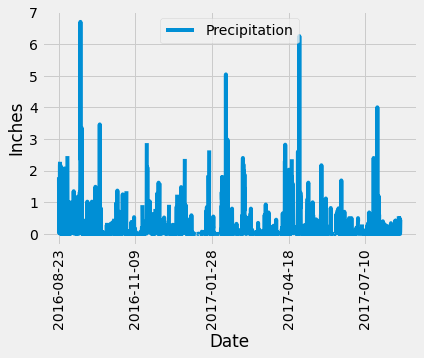

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date=dt.date(2017, 8, 23)
prev_year=last_date-dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date>=prev_year, Measurement.date<=last_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

results_df=pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date

sorted_results = results_df.sort_values(by='Date')
sorted_results.head()
# Use Pandas Plotting with Matplotlib to plot the data
barplot = sorted_results.plot(x='Date', y='Precipitation')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
barplot

In [14]:
## Use Pandas to calcualte the summary statistics for the precipitation data

summary_stat = sorted_results.groupby('Date').Precipitation.agg(['mean','median','var','std','sem'])
summary_stat

,mean,median,var,std,sem
Date,,,,,
2016-08-23,0.451667,0.100,0.499097,0.706468,0.288414
2016-08-24,1.555000,1.800,0.706510,0.840541,0.343150
2016-08-25,0.077143,0.080,0.005157,0.071813,0.027143
2016-08-26,0.016667,0.015,0.000267,0.016330,0.006667
2016-08-27,0.064000,0.020,0.006680,0.081731,0.036551
...,...,...,...,...,...
2017-08-19,0.030000,0.000,0.002700,0.051962,0.030000
2017-08-20,0.005000,0.005,0.000050,0.007071,0.005000
2017-08-21,0.193333,0.020,0.100933,0.317700,0.183424


In [15]:
# Design a query to show how many stations are available in this dataset?
number_st = session.query(Measurement.station).group_by(Measurement.station).count()
number_st 

#   

# number_st = session.query(Measurement.station, Measurement.id, Measurement.tobs).all()
# number_st_df = pd.DataFrame(number_st)
# #number_st_df.head()
# group_count = number_st_df.groupby('station').count()
# count_st = len(group_count)
# count_st

# number_station


9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_st = session.query(Measurement.station, func.count(Measurement.id))\
                    .group_by(Measurement.station)\
                    .order_by(func.count('*').desc()).all()
active_st


# active_st = number_st_df.value_counts('station')
# active_st_df = pd.DataFrame(active_st)
# active_st_df

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_281 = session.query(Measurement.station , func.min(Measurement.tobs),\
                                                  func.max(Measurement.tobs),\
                                                  func.round(func.avg(Measurement.tobs))\
                           ).\
filter(Measurement.station == 'USC00519281', Measurement.tobs).all()

station_281
# station_281_df = pd.DataFrame(station_281)
# station_281_df.head()
# most_act_stat = station_281_df.groupby('station').tobs.agg(['min', 'max', 'mean'])
# most_act_stat

[('USC00519281', 54.0, 85.0, 72.0)]

Text(0, 0.5, 'Frequency')

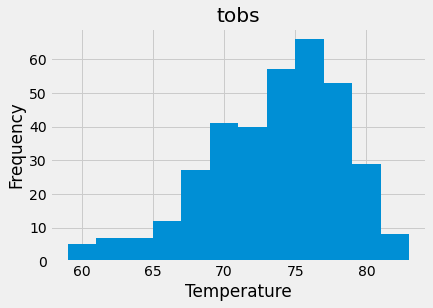

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_date=dt.date(2017, 8, 23)
prev_year=last_date-dt.timedelta(days=365)


results_2=session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.station == 'USC00519281',\
                       Measurement.date>=prev_year,\
                       Measurement.date<=last_date).all()

results_2_df = pd.DataFrame(results_2)
results_2_df.head()


results_2_df.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

## Bonus Challenge Assignment

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-22', '2017-03-05'))

[(53.0, 73.23327262649458, 86.0)]


In [70]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
last_date=dt.date(2017, 8, 23)
first_date=dt.timedelta(2010, 1, 1)
  
    
result_jun = session.query(func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs)), func.max(Measurement.tobs)).\
              filter(Measurement.date >= first_date).\
              filter(Measurement.date <= last_date).\
              filter(func.strftime("%m-%d", Measurement.date) >= '06-06').\
              filter(func.strftime("%m-%d", Measurement.date) <= '06-09').\
              group_by(Measurement.date).all()
result_jun
# function usage example


[(73.0, 76.0, 79.0),
 (69.0, 74.0, 77.0),
 (71.0, 76.0, 79.0),
 (72.0, 76.0, 80.0),
 (70.0, 74.0, 77.0),
 (68.0, 72.0, 77.0),
 (72.0, 74.0, 77.0),
 (71.0, 75.0, 77.0),
 (70.0, 73.0, 76.0),
 (71.0, 74.0, 78.0),
 (73.0, 75.0, 77.0),
 (73.0, 75.0, 77.0),
 (72.0, 76.0, 79.0),
 (71.0, 74.0, 77.0),
 (74.0, 77.0, 81.0),
 (71.0, 76.0, 79.0),
 (70.0, 74.0, 78.0),
 (73.0, 77.0, 79.0),
 (73.0, 77.0, 80.0),
 (70.0, 75.0, 79.0),
 (71.0, 77.0, 80.0),
 (72.0, 76.0, 78.0),
 (70.0, 74.0, 78.0),
 (69.0, 74.0, 79.0),
 (72.0, 75.0, 78.0),
 (71.0, 75.0, 78.0),
 (71.0, 75.0, 80.0),
 (69.0, 72.0, 76.0),
 (74.0, 77.0, 80.0),
 (75.0, 78.0, 81.0),
 (75.0, 77.0, 80.0),
 (72.0, 78.0, 81.0)]

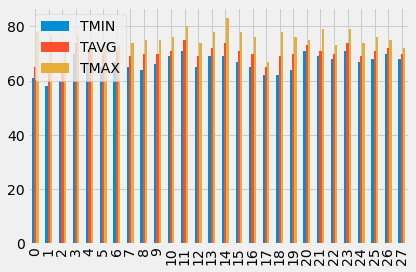

In [75]:
# Plot the results from your previous query as a bar chart. 
df = pd.DataFrame(result, columns = ['TMIN', 'TAVG', 'TMAX'])
df.plot.bar()
plt.tight_layout()
plt.show()
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [83]:
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
last_date=dt.date(2017, 8, 23)
first_date=dt.timedelta(2010, 1, 1)
  
    
result_jun = session.query(func.max(Measurement.tobs) - func.min(Measurement.tobs)).\
              filter(Measurement.date >= first_date).\
              filter(Measurement.date <= last_date).\
              filter(func.strftime("%m-%d", Measurement.date) >= '06-06').\
              filter(func.strftime("%m-%d", Measurement.date) <= '06-09').\
              group_by(Measurement.date).all()

ptps = list(np.ravel(result_jun))
ptps



[6.0,
 8.0,
 8.0,
 8.0,
 7.0,
 9.0,
 5.0,
 6.0,
 6.0,
 7.0,
 4.0,
 4.0,
 7.0,
 6.0,
 7.0,
 8.0,
 8.0,
 6.0,
 7.0,
 9.0,
 9.0,
 6.0,
 8.0,
 10.0,
 6.0,
 7.0,
 9.0,
 7.0,
 6.0,
 6.0,
 5.0,
 9.0]

NameError: name 'TAVG' is not defined

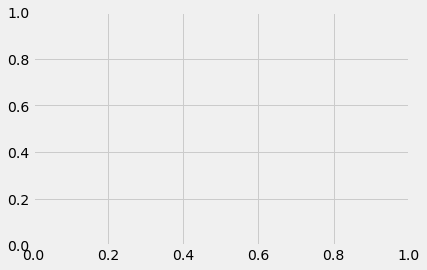

In [88]:
fig, ax = plt.subplots()

y = range(len(df))
plt.errorbar(y,TAVG)
plt.show()

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
